## Improvements for code speed
2024-12-20

In [94]:
import dataset_measure
import pathlib
import time
import pandas as pd

structure_basePath = pathlib.Path("../ressources/ISS AF_DMI_structures").absolute()
structure_folders = [structure_basePath / p for p in ['AF_DMI_structures1', 'AF_DMI_structures2', 'AF_DMI_structures3']]
solved_basePath = pathlib.Path("../ressources/ISS DMI_solved_structures").absolute()
solvedHydrogen_basePath = pathlib.Path("../ressources/ISS DMI_solved_structures hydrogens").absolute()

pathObj = {}

In [95]:
sampleStructure_name = "DOC_MAPK_RevD_3_3TEI"
sampleStructure_path = structure_folders[0] / sampleStructure_name / "ranked_0.pdb"
sampleStructure = dataset_measure.OpenStructure(sampleStructure_path)
print(type(sampleStructure[0]), type(sampleStructure[1]))

<class 'Bio.PDB.Structure.Structure'> <class 'biotite.structure.AtomArrayStack'>


In [96]:
# Tests for chains
s0 = sampleStructure[0]
chains = [c for c in s0.get_chains()]
assert len(chains) == 2

chain1 = s0[0][chains[0].id]
chain2 = s0[0][chains[1].id]


#### Benchmark

In [97]:
def EvaluateStructure_Benchmark(path: pathlib.Path, structure_name: str = "") -> dict|None:
    """
        Measures the pdb file given by path
    """
    _startTime = time.time()

    file_name = path.name
    structure, structure_biotite = dataset_measure.OpenStructure(path, structure_name)
    _timea1 = time.time()
    if structure is None or structure_biotite is None: return None

    buried_area = dataset_measure.calculate_buried_area(structure)
    _timeb1 = time.time()
    hbonds = dataset_measure.find_h_bonds(structure, structure_biotite)
    _timeb2 = time.time()
    min_distance = dataset_measure.minimum_interface_distance(structure)
    _timeb3 = time.time()
    salt_bridges = dataset_measure.find_salt_bridges(structure)
    _timeb4 = time.time()
    hydrophobic_interactions = dataset_measure.find_hydrophobic_interactions(structure)
    _timeb5 = time.time()

    print(f"Opening Structure: {round((_timea1 - _startTime)*1000, 0)} ms")
    print(f"Buried surface Area: {round((_timeb1 - _timea1)*1000, 0)} ms")
    print(f"H Bonds: {round((_timeb2 - _timeb1)*1000, 0)} ms")
    print(f"Min. Interface Distance: {round((_timeb3 - _timeb2)*1000, 0)} ms")
    print(f"Salt bridges: {round((_timeb4 - _timeb3)*1000, 0)} ms")
    print(f"Hydrophobic interactions: {round((_timeb5 - _timeb4)*1000, 0)} ms")
    print(f"Total: {round((_timeb5 - _startTime), 3)} s")

    return {
        'structure_name': structure_name,
        'file': file_name,
        'hbonds': hbonds,
        'salt_bridges': salt_bridges,
        'buried_area': buried_area,
        'min_distance': min_distance,
        'hydrophobic_interactions': hydrophobic_interactions
    }

EvaluateStructure_Benchmark(sampleStructure_path, sampleStructure_name)

# AF DOC_MAPK_RevD_3_3TEI
# 
# Opening Structure: 55.0 ms
# Buried surface Area: 2097.0 ms
# H Bonds: 32.0 ms
# Min. Interface Distance: 5.0 ms
# Salt bridges: 4.0 ms
# Hydrophobic interactions: 81.0 ms
# Total: 0.081 s

Opening Structure: 57.0 ms
Buried surface Area: 2133.0 ms
H Bonds: 82.0 ms
Min. Interface Distance: 4.0 ms
Salt bridges: 4.0 ms
Hydrophobic interactions: 83.0 ms
Total: 2.362 s


{'structure_name': 'DOC_MAPK_RevD_3_3TEI',
 'file': 'ranked_0.pdb',
 'hbonds': 13,
 'salt_bridges': 10,
 'buried_area': 1619.277,
 'min_distance': 4.612277290736174,
 'hydrophobic_interactions': 14}

#### Improving SASA calculations

In [15]:
from rust_sasa_python import calculate_sasa_at_atom_level
residue_sasa_values = calculate_sasa_at_atom_level(str(sampleStructure_path)) # Also supports mmCIF files!

In [ ]:
residue_sasa_values

In [3]:
import biotite.structure.sasa as sasa
import biotite.structure as struc

In [5]:
atom_array = sampleStructure[1][0]
atom_array

array([
	Atom(np.array([ -3.439, -26.476, -24.607], dtype=float32), chain_id="A", res_id=1, ins_code="", res_name="GLY", hetero=False, atom_name="N", element="N"),
	Atom(np.array([ -3.467, -26.762, -23.638], dtype=float32), chain_id="A", res_id=1, ins_code="", res_name="GLY", hetero=False, atom_name="H", element="H"),
	Atom(np.array([ -3.358, -27.285, -25.206], dtype=float32), chain_id="A", res_id=1, ins_code="", res_name="GLY", hetero=False, atom_name="H2", element="H"),
	Atom(np.array([ -4.298, -25.98 , -24.799], dtype=float32), chain_id="A", res_id=1, ins_code="", res_name="GLY", hetero=False, atom_name="H3", element="H"),
	Atom(np.array([ -2.301, -25.558, -24.804], dtype=float32), chain_id="A", res_id=1, ins_code="", res_name="GLY", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([ -1.365, -26.054, -24.547], dtype=float32), chain_id="A", res_id=1, ins_code="", res_name="GLY", hetero=False, atom_name="HA2", element="H"),
	Atom(np.array([ -2.268, -25.214, -25.838], dtype=f

In [11]:
chain1_atoms = atom_array[atom_array.chain_id == chains[0].id]
chain2_atoms = atom_array[atom_array.chain_id == chains[1].id]

In [12]:
sasa1 = sasa(chain1_atoms)
sasa2 = sasa(chain2_atoms)
sasa12 = sasa(atom_array)
d = {}
for i, s in enumerate(sasa12):
    d[i] = {
        "resname": atom_array[i].res_name, 
        "atom_name": atom_array[i].atom_name,  
        "sasa": s
    }
df = pd.DataFrame(d).transpose()

In [ ]:
sasa12

In [20]:
df

,resname,atom_name,sasa
0,GLY,N,53.653622
1,GLY,H,NaN
2,GLY,H2,NaN
3,GLY,H3,NaN
4,GLY,CA,38.935886
...,...,...,...
5935,ARG,NH2,0.0
5936,ARG,HH21,NaN
5937,ARG,HH22,NaN
5938,ARG,CZ,0.0


In [ ]:
print(len(chain1_atoms), len(chain2_atoms), len(atom_array), len(chain1_atoms)+ len(chain2_atoms))

In [75]:
# With Biopandas

In [14]:
from Bio.PDB import ShrakeRupley
import numpy as np

In [15]:
structure = sampleStructure[0]
chains = [c for c in structure.get_chains()]

# Calculate SASA for the whole structure
sasa = ShrakeRupley()
sasa.compute(structure, level="A")
total_area = np.sum(atom.sasa for atom in structure.get_atoms())

# Calculate buried area for each chain separately
chain1 = structure[0][chains[0].id]
chain2 = structure[0][chains[1].id]

sasa.compute(chain1, level="A")
area_ch1 = np.sum(atom.sasa for atom in chain1.get_atoms())

sasa.compute(chain2, level="A")
area_ch2 = np.sum(atom.sasa for atom in chain2.get_atoms())

# Calculate buried area
buried_area = (area_ch1 + area_ch2 - total_area)

C:\Users\abril\AppData\Local\Temp\ipykernel_63172\1996959214.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  total_area = np.sum(atom.sasa for atom in structure.get_atoms())
C:\Users\abril\AppData\Local\Temp\ipykernel_63172\1996959214.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  area_ch1 = np.sum(atom.sasa for atom in chain1.get_atoms())
C:\Users\abril\AppData\Local\Temp\ipykernel_63172\1996959214.py:17: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  area_ch2 = np.sum(atom.sasa for atom in chain2.get_atoms())


In [16]:
sasa = ShrakeRupley()
sasa.compute(structure, level="A")

In [17]:
x = [{"resname": a.get_parent().resname, "atom_name": a.element, "sasa": a.sasa} for a in structure.get_atoms()]

In [18]:
x

[{'resname': 'GLY', 'atom_name': 'N', 'sasa': 1.0935884027146072},
 {'resname': 'GLY', 'atom_name': 'H', 'sasa': 23.785626298859036},
 {'resname': 'GLY', 'atom_name': 'H', 'sasa': 28.033059566512435},
 {'resname': 'GLY', 'atom_name': 'H', 'sasa': 20.387679684736316},
 {'resname': 'GLY', 'atom_name': 'C', 'sasa': 1.2076282160399163},
 {'resname': 'GLY', 'atom_name': 'H', 'sasa': 18.688706377674958},
 {'resname': 'GLY', 'atom_name': 'H', 'sasa': 18.688706377674958},
 {'resname': 'GLY', 'atom_name': 'C', 'sasa': 3.622884648119749},
 {'resname': 'GLY', 'atom_name': 'O', 'sasa': 12.857508288752644},
 {'resname': 'PRO', 'atom_name': 'N', 'sasa': 0.0},
 {'resname': 'PRO', 'atom_name': 'C', 'sasa': 0.0},
 {'resname': 'PRO', 'atom_name': 'H', 'sasa': 0.8494866535306799},
 {'resname': 'PRO', 'atom_name': 'C', 'sasa': 0.0},
 {'resname': 'PRO', 'atom_name': 'C', 'sasa': 0.0},
 {'resname': 'PRO', 'atom_name': 'H', 'sasa': 0.0},
 {'resname': 'PRO', 'atom_name': 'H', 'sasa': 0.0},
 {'resname': 'PRO',

Oh boy..

In [29]:
sampleStructure[1][0].atom_name

array(['N', 'H', 'H2', ..., 'HH22', 'CZ', 'OXT'], dtype='<U6')

In [82]:
import matplotlib.pyplot as plt
import time

In [84]:
from rust_sasa_python import calculate_sasa_at_atom_level
import biotite.structure.sasa as sasa
import biotite.structure as struc
from Bio.PDB import ShrakeRupley
import numpy as np

d = []
for a in sampleStructure[1][0]:
    d.append({
        "Chain": a.chain_id,
        "Residue": a.res_name,
        "Atom": a.atom_name,
        "Element": a.element
    })
df = pd.DataFrame(d)

t0 = time.time()
residue_sasa_values = calculate_sasa_at_atom_level(str(sampleStructure_path), n_points=100, probe_radius=1.4)
df["RustSASA"] = residue_sasa_values
t1 = time.time()

sasa12 = sasa(sampleStructure[1][0], ignore_ions=False, probe_radius=1.4, point_number=100)
df["Biotite SASA"] = sasa12
t2 = time.time()

sasaSR = ShrakeRupley(probe_radius=1.4, n_points=100)
sasaSR.compute(sampleStructure[0], level="A")
df["Biopandas SASA"] = [a.sasa for a in structure.get_atoms()]
t3 = time.time()

sasaOnline = [] # https://curie.utmb.edu/getarea.html; r=1.4A, no water gradient
with open("dev/2024-12-20 onlineSASAoutput.txt", "r") as f:
    while (line := f.readline()):
        com = line.strip("\n").split(" ")
        if len(com) <= 2:
            continue
        sasaOnline.append(float(com[-1]))
df["Curie UTMB SASA"] = sasaOnline

dfHless = df[df["Element"] != "H"]

print(f"RustSASA: {round((t1 - t0)*1000, 0)} ms")
print(f"Biotite SASA: {round((t2 - t1)*1000, 0)} ms")
print(f"Biopandas SASA: {round((t3 - t2)*1000, 0)} ms")

df

RustSASA: 55.0 ms
Biotite SASA: 28.0 ms
Biopandas SASA: 1101.0 ms


,Chain,Residue,Atom,Element,RustSASA,Biotite SASA,Biopandas SASA,Curie UTMB SASA
0,A,GLY,N,N,5.883323,56.905354,1.093588,41.54
1,A,GLY,H,H,19.538193,NaN,23.785626,0.00
2,A,GLY,H2,H,27.183571,NaN,28.033060,0.00
3,A,GLY,H3,H,20.387678,NaN,20.387680,0.00
4,A,GLY,CA,C,2.525564,40.558212,1.207628,50.24
...,...,...,...,...,...,...,...,...
5935,B,ARG,NH2,N,0.000000,0.000000,0.000000,0.00
5936,B,ARG,HH21,H,0.000000,NaN,0.000000,0.00
5937,B,ARG,HH22,H,0.000000,NaN,0.000000,0.00
5938,B,ARG,CZ,C,0.000000,0.000000,0.000000,0.00


In [65]:
x = df[df["Element"] != "H"]
x

,Chain,Residue,Atom,Element,RustSASA,Biotite SASA,Biopandas SASA,Curie UTMB SASA
0,A,GLY,N,N,5.883323,56.905354,1.093588,41.54
4,A,GLY,CA,C,2.525564,40.558212,1.207628,50.24
7,A,GLY,C,C,6.313910,2.277051,3.622885,0.59
8,A,GLY,O,O,13.738814,19.986561,12.857508,18.38
9,A,PRO,N,N,0.000000,1.161334,0.000000,0.03
...,...,...,...,...,...,...,...,...
5930,B,ARG,NE,N,0.000000,0.000000,0.000000,0.00
5932,B,ARG,NH1,N,0.000000,1.161334,0.000000,0.59
5935,B,ARG,NH2,N,0.000000,0.000000,0.000000,0.00
5938,B,ARG,CZ,C,0.000000,0.000000,0.000000,0.00


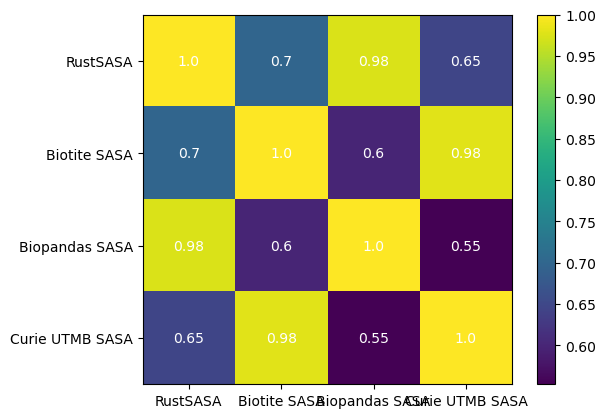

In [93]:
columns = ["RustSASA", "Biotite SASA", "Biopandas SASA", "Curie UTMB SASA"]
corr_input = []
for i in range(len(columns)):
    corr_input.append(np.array(dfHless[columns[i]]))
corr_input = np.array(corr_input)
correlations = np.corrcoef(corr_input)

ims = plt.imshow(correlations)
plt.colorbar(ims)
plt.xticks(range(len(columns)), labels=columns)
plt.yticks(range(len(columns)), labels=columns)
for i in range(len(columns)):
    for j in range(len(columns)):
        text = plt.text(j, i, round(correlations[i, j],2), ha="center", va="center", color="w")
plt.show()

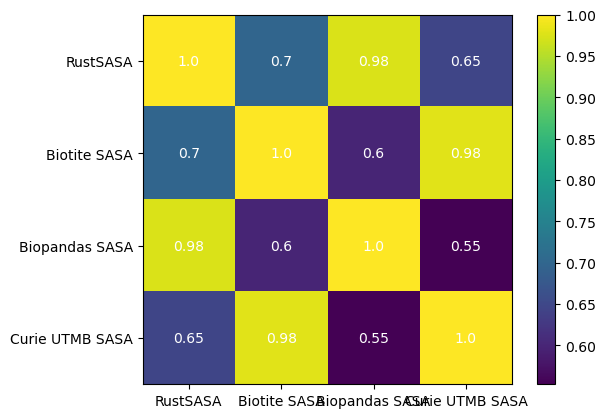

In [ ]:
columns = ["RustSASA", "Biotite SASA", "Biopandas SASA", "Curie UTMB SASA"]
corr_input = []
for i in range(len(columns)):
    corr_input.append(np.array(dfHless[columns[i]]))
corr_input = np.array(corr_input)

correlations = np.zeros(shape=(4,4))
for i1,x in enumerate(columns):
    for i2,y in enumerate(columns):
        correlations[i1,i2] = np.corrcoef(dfHless[x], dfHless[y])[1,0]
ims = plt.imshow(correlations)
plt.colorbar(ims)
plt.xticks(range(len(columns)), labels=columns)
plt.yticks(range(len(columns)), labels=columns)
for i in range(len(columns)):
    for j in range(len(columns)):
        text = plt.text(j, i, round(correlations[i, j],2), ha="center", va="center", color="w")
plt.show()

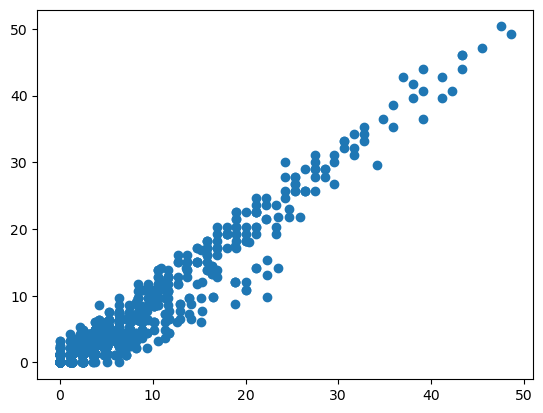

In [78]:
plt.scatter(dfHless["RustSASA"], dfHless["Biopandas SASA"])
plt.show()

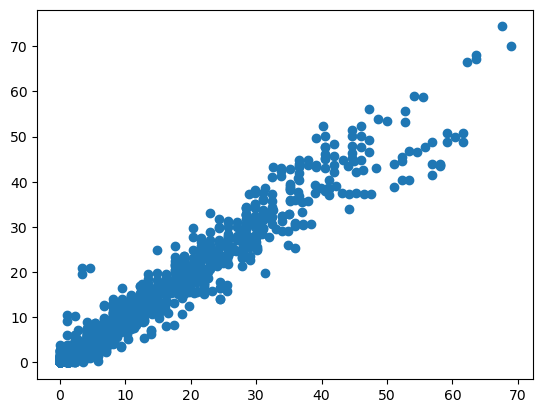

In [79]:
plt.scatter(dfHless["Biotite SASA"], dfHless["Curie UTMB SASA"])
plt.show()

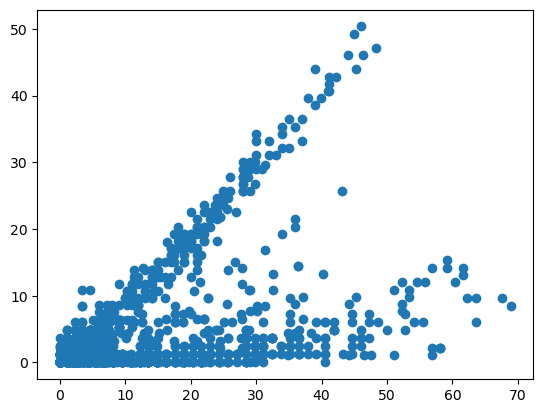

In [85]:
plt.scatter(dfHless["Biotite SASA"], dfHless["Biopandas SASA"])
plt.show()